# **Gemini for Data Scientists**
## Objectives
In this lab, you learn how to perform the following tasks:

* Use Colab Enterprise Python notebooks inside BigQuery Studio.
* Use BigQuery DataFrames inside of BigQuery Studio.
* Use Gemini to generate code from natural language prompts.
* Build a K-means clustering model.
* Generate a visualization of the clusters.
* Use the text-bison model to develop the next steps for a marketing campaign.
* Clean up project resources.

---
## **Task 1.** Create a BigQuery dataset for your project
In this task, you will create the ecommerce dataset in BigQuery. The dataset will be used to store the ecommerce data you will categorize in this lab.

In the Google Cloud console, select the `Navigation menu (Navigation menu icon)`, and then select `BigQuery`.


In the Explorer panel, for `<your project ID>` , select View actions (More menu icon), and then select `Create dataset`.

In the `Create dataset` pane, enter the following information:


| Field |	Value |
|-------|-------|
| Dataset ID |	ecommerce |
| Location type |	select **Multi-Region** |
| Multi-region	| select **US (multiple regions in United States)** |
Leave the other fields at their defaults.

Click **Create Dataset**.

## **Task 2.** Create a new Python notebook
In this task, you create a new Python notebook in BigQuery, so that you may use Gemini in BigQuery. The Python notebook is needed in BigQuery so that you may use Python machine learning libraries to identify customers and categorize them into groups, based upon shopping data in the ecommerce dataset.

In the Google Cloud console, select the Navigation menu (Navigation menu icon), and then select **BigQuery**.

At the top of the page, click the down arrow next to the plus sign.

Select **Python Notebook**.

Select the region **us-central1** to store your code assets from the dropdown and click **Select**.

In the Start with a template pane, click **Close**.

```|--- can also use Google Colab for this project, but need to create a bigquerydataset and enable google relevant apis for accessing directly through colab ---|```

In [19]:
#Import Python libraries and define variables

from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split


##### The table below provides more information about the Python libraries that you just imported to your notebook, including a brief description about each one.

| Library |	Description |
|---------|-------------|
| BigQuery	| Python Client for Google BigQuery |
| AI Platform	| Vertex AI SDK for Python |
| bigframes.pandas	| BigQuery DataFrames |
| pandas	| Open source data analysis and | manipulation tool, built on top of the Python programming language. |
| TextGenerationModel	| Creates a LanguageModel within VertexAI. |
| Kmeans | Used to create K-means clustering models within BigQuery DataFrames |
| train_test_split	| Used to split source dataset into test and training subsets, and used with model tuning within BigQuery DataFrames. |

In [20]:
project_id = 'qwiklabs-gcp-01-9a28495ad825' #use your own proejct id
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1" #<location needed>
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [21]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [22]:
bqdf = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
bqdf.head(10)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Reading cached table from 2024-10-02 06:37:26.052142+00:00 to avoid incompatibilies with previous reads of this table. To read the latest version, set `use_cache=False` or close the current session with Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.10/dist-packages/bigframes/session/_io/bigquery/read_gbq_table.py:140: TimeTravelDisabledWarning: NotFound error when reading table with time travel. Attempting query without time travel. Warning: Without time travel, modifications to the underlying table may result in errors or unexpected behavior.
  warnings.warn(


,user_id,days_since_last_order,count_orders,average_spend
0,67253,795,1,75.0
1,23179,841,1,42.0
2,65298,767,1,225.0
3,10115,706,3,65.833333
4,55165,940,2,54.975
5,55850,830,4,46.6725
6,32212,1003,1,14.0
7,70961,886,1,49.5
8,69722,967,4,43.084999
9,64705,668,1,54.0


In [23]:
# prompt: 1. Split df (using random state and test size 0.2) into test and training data for a K-means clustering algorithm store these as df_test and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model using the to_gbq method where the model name is project_id.dataset_name.model_name.

df_train, df_test = train_test_split(bqdf, test_size=0.2, random_state=42)
kmeans = KMeans(n_clusters=5)
model = kmeans.fit(df_train)
model.to_gbq(f"{project_id}.{dataset_name}.{model_name}")

KMeans(distance_type='EUCLIDEAN', init='KMEANS_PLUS_PLUS', n_clusters=5)

In [24]:
# prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.

predictions_df = kmeans.predict(df_test)
predictions_df.head(10)

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
3,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.670205328090...",10115,706,3,65.833333
10,3,"[{'CENTROID_ID': 3, 'DISTANCE': 2.400065433662...",5591,916,1,276.320007
23,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.526923661136...",81604,726,1,70.0
24,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.785114278111...",86643,651,1,42.990002
27,1,"[{'CENTROID_ID': 1, 'DISTANCE': 0.920726823474...",48440,860,2,62.494999
30,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.289167154298...",44186,666,3,46.25
31,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.774808509849...",12428,886,1,12.0
50,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.533787090687...",77784,682,2,41.805
56,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.260857506316...",29052,847,1,17.84
57,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.339436194872...",79520,970,2,17.995


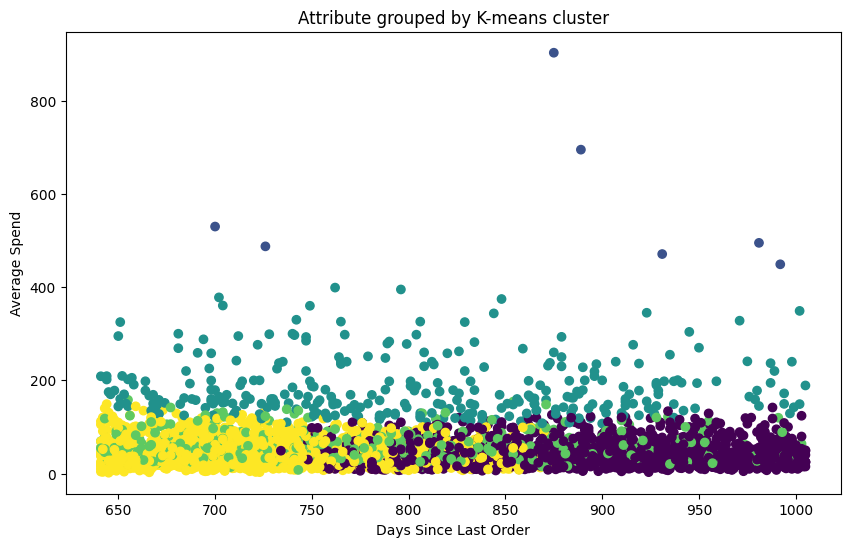

In [25]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."

import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'], cmap='viridis')

# Add labels and title
plt.xlabel('Days Since Last Order')
plt.ylabel('Average Spend')
plt.title('Attribute grouped by K-means cluster')

# Show the plot
plt.show()

In [26]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,43.46,1.28,885.04
1,cluster 2,671.90,1.28,781.58
2,cluster 3,183.09,1.25,811.64
3,cluster 4,58.01,3.70,776.47
4,cluster 5,45.57,1.30,723.95


In [27]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $43.46, count of orders per person 1.28, days since last order 885.04
cluster 2, average spend $671.9, count of orders per person 1.28, days since last order 781.58
cluster 3, average spend $183.09, count of orders per person 1.25, days since last order 811.64
cluster 4, average spend $58.01, count of orders per person 3.7, days since last order 776.47
cluster 5, average spend $45.57, count of orders per person 1.3, days since last order 723.95


In [28]:
prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

In [29]:
#prompt:  Use the Vertex AI language_models API to call the PaLM2 text-bison model and generate a marketing campaign using the variable prompt. Use the following model settings: max_output_tokens=1024, temperature=0.4

model = TextGenerationModel.from_pretrained("text-bison@001")
response = model.predict(prompt, max_output_tokens=1024, temperature=0.4)

print(response.text)

**Cluster 1**

* Title: The Casual Shopper
* Persona: This is someone who enjoys shopping for everyday items, but doesn't want to spend a lot of money. They are typically looking for good deals and are not afraid to shop around.
* Next marketing step: Send this persona coupons and promo codes for their favorite items. You could also offer them a loyalty program that rewards them for their purchases.

**Cluster 2**

* Title: The Luxury Shopper
* Persona: This is someone who enjoys shopping for high-end items and is not afraid to spend money. They are typically looking for the best quality products and are willing to pay a premium for them.
* Next marketing step: Send this persona emails about new products and sales. You could also host events or trunk shows where they can see and try out new items.

**Cluster 3**

* Title: The Impulsive Shopper
* Persona: This is someone who makes impulse purchases and is not always very careful about their spending. They are typically looking for somet